https://pytorch.org/docs/stable/library.html

```
    node -e 'console.log(require("./workbench/report.json"))'
```

In [1]:
## Initialization
from typing import Callable

from cgtnnlib.EvaluationParameters import EvaluationParameters
from cgtnnlib.ExperimentParameters import ExperimentParameters
from cgtnnlib.PlotModel import PlotModel
from cgtnnlib.Report import Report, eval_report_key
from cgtnnlib.common import DATASETS, LEARNING_RATE, eval_inner
from cgtnnlib.training import train_model

from cgtnnlib.nn.NetworkLike import NetworkLike
from cgtnnlib.nn.AugmentedReLUNetwork import AugmentedReLUNetwork
from cgtnnlib.nn.DenserAugmentedReLUNetwork import DenserAugmentedReLUNetwork


REPORT = Report(dir="workbench/")
DATASET = DATASETS[2] #3
EPOCHS = 10
# PP = [0.1, 0.5, 0.7, 0.9]
#PP = [0.8, 1.0]
PP = [0.1, 0.5, 0.7, 0.8, 0.9, 1.0]
ITERATIONS = 10


MODEL_CONSTRUCTORS: list[Callable[[int, int, float], NetworkLike]] = [
    AugmentedReLUNetwork,
    DenserAugmentedReLUNetwork,
]



MODEL_CONSTRUCTORS

[cgtnnlib.nn.AugmentedReLUNetwork.AugmentedReLUNetwork,
 cgtnnlib.nn.DenserAugmentedReLUNetwork.DenserAugmentedReLUNetwork]

In [2]:
## Training and evaluation
import torch.optim as optim

from cgtnnlib.training import save_model_to_path


for iteration in range(1, ITERATIONS + 1):
    for p in PP:
        for constructor in MODEL_CONSTRUCTORS:
            experiment_params = ExperimentParameters(
                iteration=iteration,
                p=p
            )

            # Training

            model = constructor(
                inputs_count=DATASET.features_count,
                outputs_count=DATASET.classes_count,
                p=experiment_params.p,
            )
            
            running_losses = train_model(
                model=model,
                dataset=DATASET,
                epochs=EPOCHS,
                experiment_params=experiment_params,
                criterion=DATASET.learning_task.criterion,
                optimizer=optim.Adam(
                    model.parameters(),
                    lr=LEARNING_RATE,
                )
            )

            model_path = DATASET.model_path(experiment_params, model)

            save_model_to_path(model, model_path)

            REPORT.record_running_losses(running_losses,
                                         model,
                                         DATASET,
                                         experiment_params)

            # Evaluation

            eval_params = EvaluationParameters(
                dataset=DATASET,
                model_path=model_path,
                experiment_parameters=experiment_params,
                report_key=eval_report_key(
                    model_name=constructor.__name__,
                    dataset_number=DATASET.number,
                    p=p,
                    iteration=iteration,
                )
            )

            eval_inner(
                eval_params=eval_params,
                experiment_params=experiment_params,
                constructor=constructor
            )

REPORT.see()
REPORT.save()

Evaluating model at pth/cgtnn-3X-DenserAugmentedReLUNetwork-c-P1.0_N10.pth...
Evaluation of regression (head):
   noise_factor        r2        mse
0          0.00 -0.890853  29.107496
1          0.04 -0.890905  29.108297
2          0.08 -0.890807  29.106791
3          0.12 -0.891909  29.123743
4          0.16 -0.890548  29.102795
Report workbench/report.json
started: '2024-12-05T15:34:20.477499'
loss_AugmentedReLUNetwork_3_p0.8_N1: list(4360 items)
evaluate_AugmentedReLUNetwork_3_p0.8_N1: dict(...)
loss_DenserAugmentedReLUNetwork_3_p0.8_N1: list(4360 items)
evaluate_DenserAugmentedReLUNetwork_3_p0.8_N1: dict(...)
loss_AugmentedReLUNetwork_3_p1.0_N1: list(4360 items)
evaluate_AugmentedReLUNetwork_3_p1.0_N1: dict(...)
loss_DenserAugmentedReLUNetwork_3_p1.0_N1: list(4360 items)
evaluate_DenserAugmentedReLUNetwork_3_p1.0_N1: dict(...)
loss_AugmentedReLUNetwork_3_p0.8_N2: list(4360 items)
evaluate_AugmentedReLUNetwork_3_p0.8_N2: dict(...)
loss_DenserAugmentedReLUNetwork_3_p0.8_N2: list(436

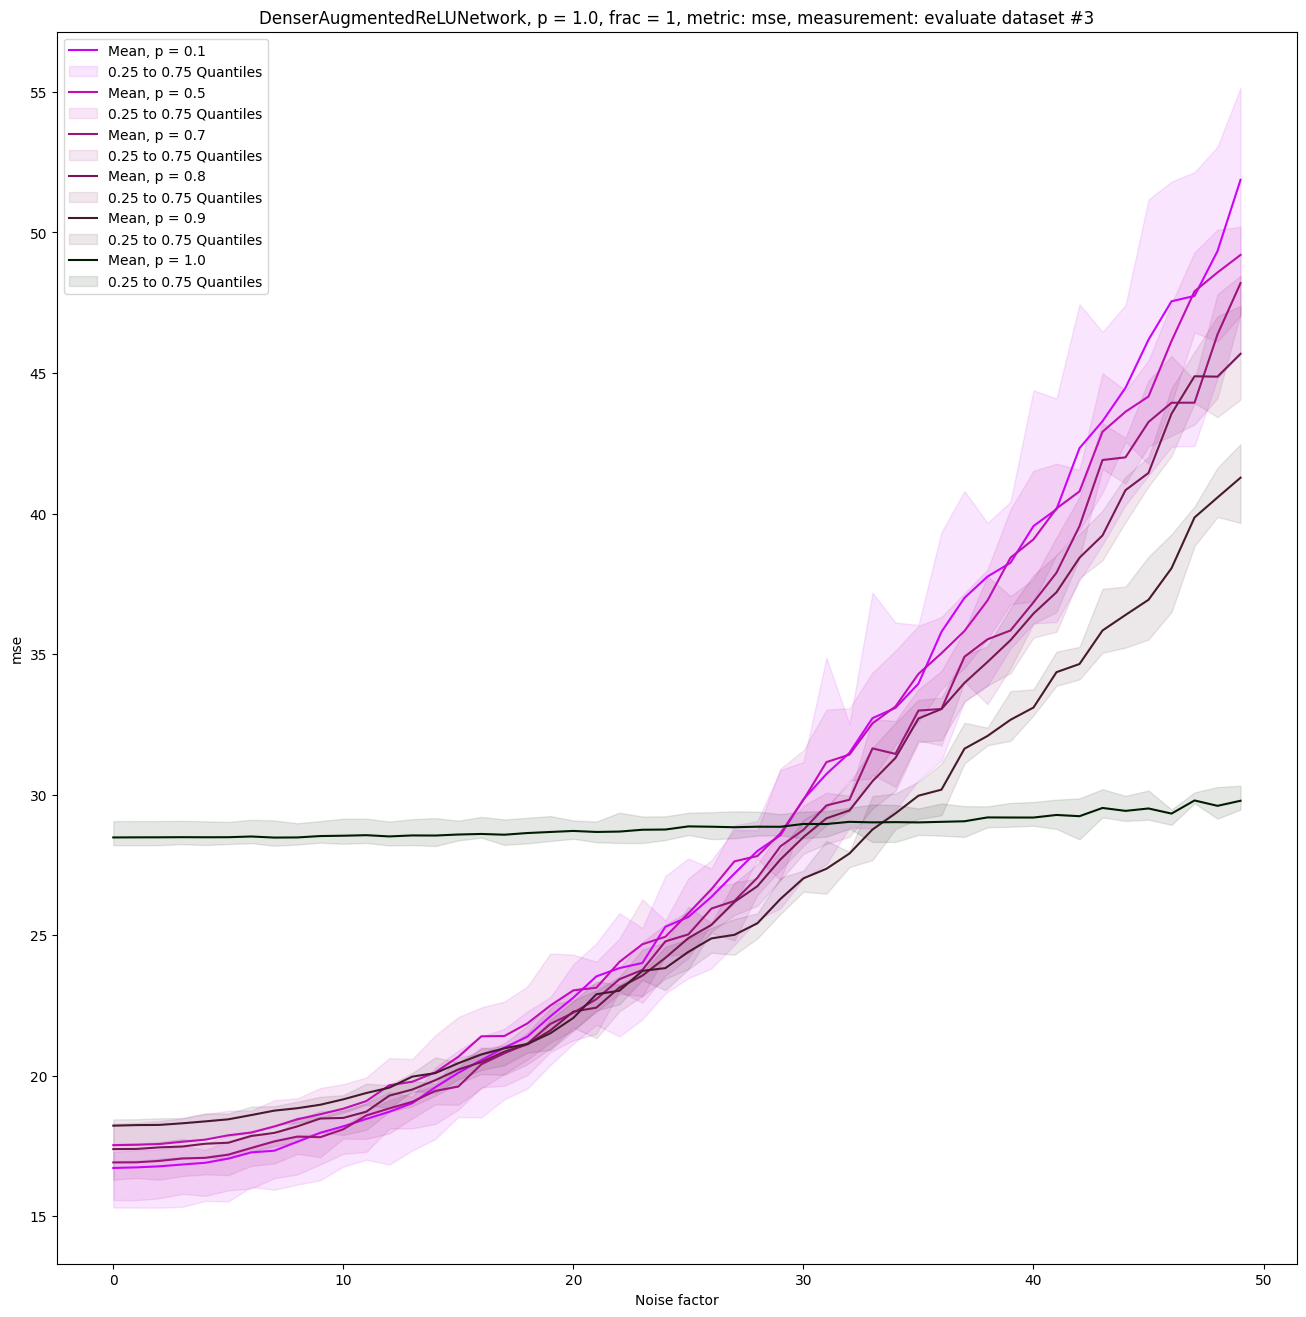

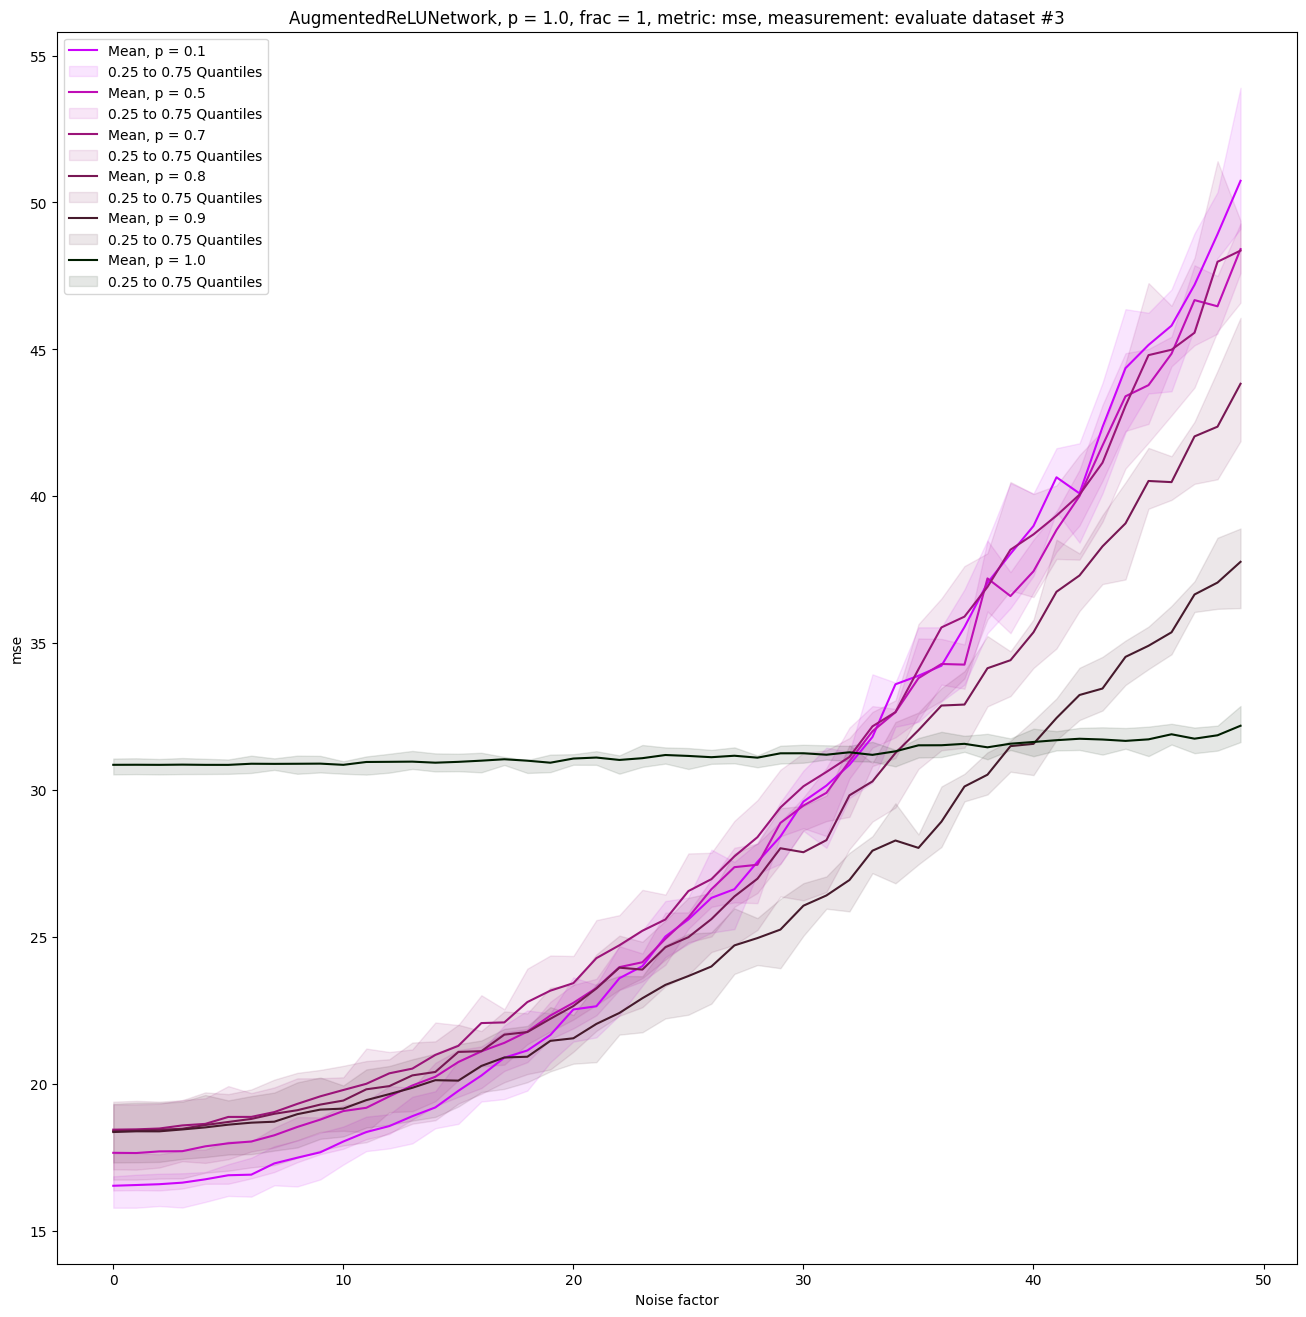

In [10]:
import matplotlib.pyplot as plt

from cgtnnlib.analyze import plot_deviant_curves_on_ax_or_plt, search_curve_in_report

# MEASUREMENT='loss'
# METRIC='loss'
# FRAC=0.0125*8
# # FRAC=1

# MEASUREMENT='evaluate'
# METRIC='r2'
# FRAC=1

MEASUREMENT='evaluate'
METRIC='mse'
FRAC=1

report_path = 'reports/6pp.json'

if MEASUREMENT == 'evaluate':
    XLABEL = 'Noise factor'
else:
    XLABEL = 'Training iteration'

def color_of_p(p: float) -> tuple[int, int, int]:
    return ((1 - p**4) * 0.8, (p ** 1/8) * 0.9, 1 - (p ** 1.8))

for model_name in ['DenserAugmentedReLUNetwork', 'AugmentedReLUNetwork']:
    plt.figure(figsize=(16, 16))

    for p in PP:
        CURVE = search_curve_in_report(
            report_path=report_path,
            model=PlotModel(
                measurement=MEASUREMENT,
                dataset_number=DATASET.number,
                model_name=model_name,
                metric=METRIC,
                p=p,
                frac=FRAC,
            )
        )

        color = color_of_p(p)
        plot_deviant_curves_on_ax_or_plt(
            ax_or_plt=plt,
            models=[{
                'curve': CURVE,
                'color': color,
                'label': f'Mean, p = {p}',
                'quantiles_color': color,
                'quantiles_label': '0.25 to 0.75 Quantiles',
            }],
            title=f'{model_name}, p = {p}, frac = {FRAC}, metric: {METRIC}, measurement: {MEASUREMENT} dataset #{DATASET.number}',
            xlabel=XLABEL,
            ylabel=METRIC,
            quantiles_alpha=0.1,
        )

    plt.show()